<a href="https://colab.research.google.com/github/carlos20160984/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity2_Draft_Carlos_Santiago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-26' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20160984" #@param {type:"string"}
Student_full_name = "Carlos Santiago" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# To find Feature Importnces
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [4]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The challenge is to predict the final price of each house.

In [165]:
# Import the data
Path = '/content/drive/MyDrive/etivity-2/'

# House prices Data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
true_data = Path + 'true_price.csv'

# train data
train = pd.read_csv(train_data)

# test data
test = pd.read_csv(test_data)
true_data=pd.read_csv(true_data )
test.insert(1, "price", true_data["Expected"])

## Exploratory Data Analysis (EDA)

In [55]:
# View the first 5 rows of training set
train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [56]:
# Describe the training set
train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [57]:
# Describe the testing set
test.describe()

,ad_id,price,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,5.810356e+05,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,6.009194e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,8.500000e+04,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,2.950000e+05,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,4.250000e+05,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,5.950000e+05,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,5.750000e+06,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


In [58]:
print("Property type of cases where beds = 0")
train.loc[train['beds']==0,"property_type"].value_counts(sort=False)

Property type of cases where beds = 0


terraced     3
site        52
detached     1
Name: property_type, dtype: int64

In [59]:
# Check for missing values in the training data: total missing
print("Count of missing values")
train.isna().sum()

Count of missing values


ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [60]:
# Check for missing values: 
print('% of missing values')
(train.isna().sum()/len(train))*100

% of missing values


ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64

Pairplots of numerical features


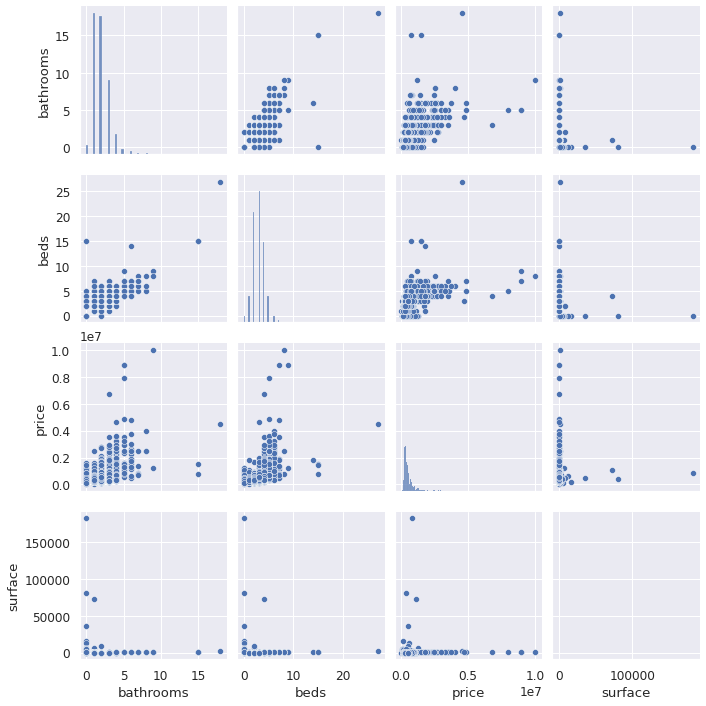

In [61]:
# Pairplot to see the relationship between numerical features. The method dropna() drops all rows with missing values 
# No of units and facility are removed due to high number of NULL values
print('Pairplots of numerical features')
sns.pairplot(data=train[['area','bathrooms','beds','price','surface']].dropna())
plt.show()

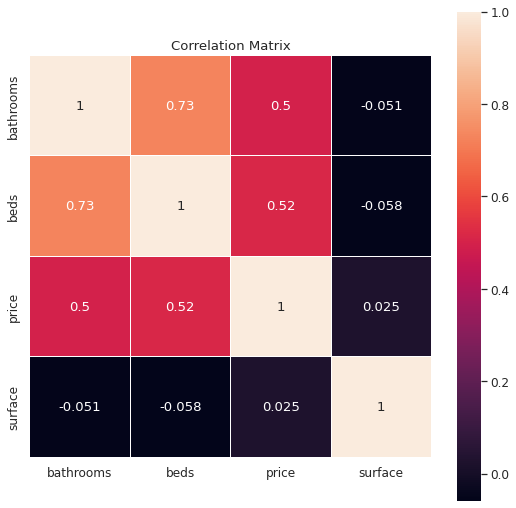

In [62]:
# Check relationships between numerical variables

train[['area','bathrooms','beds','price','surface']].dropna()

sns.set(font_scale=1.10)
plt.figure(figsize=(9, 9))
plt.title('Correlation Matrix')
sns.heatmap(train[['area','bathrooms','beds','price','surface']].corr(),linewidths=0.01,
            square=True,annot=True)


Text(0.5, 1.0, 'Count of BER for 2nd hand properties')

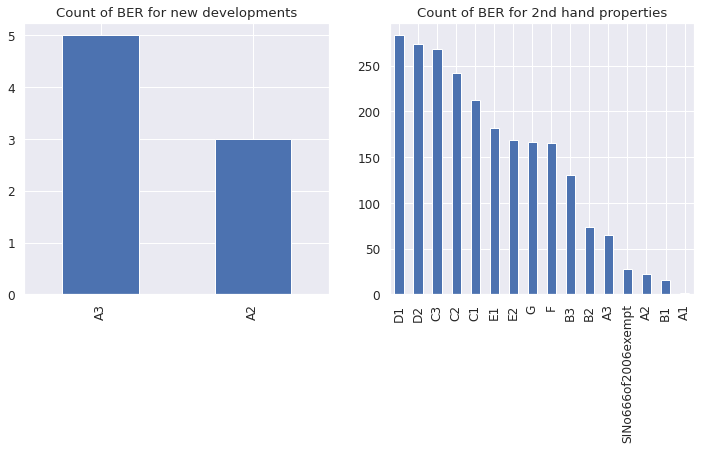

In [70]:
# Plot couting of BER rating by property category 

ber_new=train[train['property_category']=='new_development_parent']
ber_used=train[train['property_category']=='sale']


plt.subplots(2,2,figsize=(12,5))
plt.subplot(1, 2, 1) 
ber_new['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for new developments')
plt.subplot(1, 2, 2) 
ber_used['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for 2nd hand properties')


Text(0.5, 1.0, 'Number of properties by type')

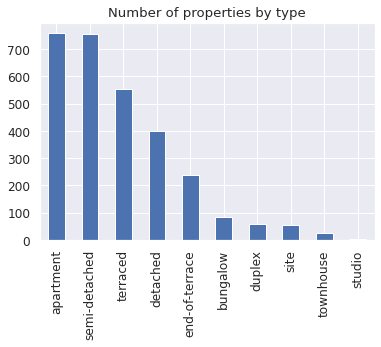

In [73]:
# Plot count and frequency of type
train['property_type'].value_counts(sort=True).plot(kind='bar')
plt.title('Number of properties by type')



Boxplot of each property type


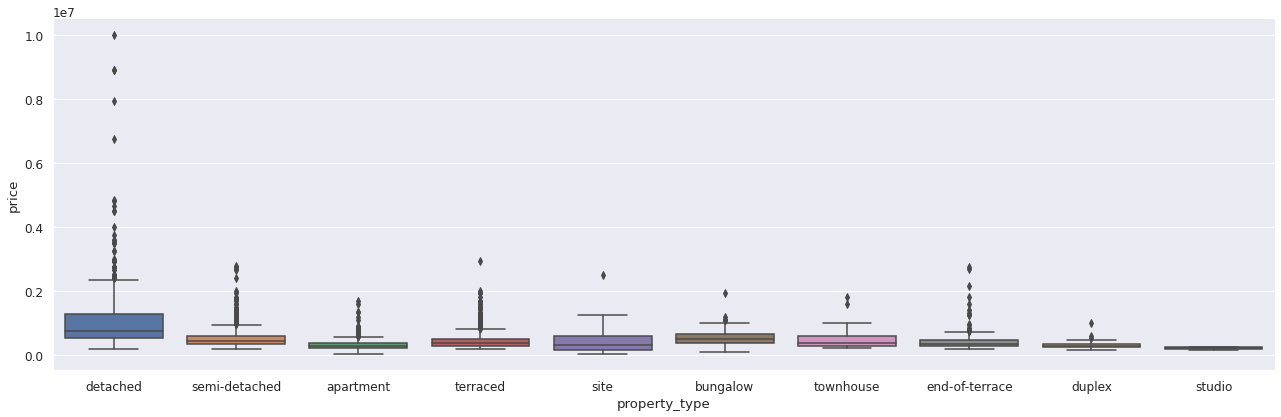

In [65]:
"""Generate two plots with the combined distribution of attributes and draw conclusions from them"""

# Boxplot of each property type
print("Boxplot of each property type")
sns.catplot(data=train, x='property_type', y='price', kind='box', height=6, aspect=15/5)

**Summary EDA: train data**

* 1.7% of new developments are missing *price, bathroom, beds, BER, facilities,features and property type* data. These are all entries of new developments where up to 36 properties were recorded together.  
* 56 properties have beds: 52 sites, 3 detached and 1 terraced.
* A further 38 instances of second hand properties are missing price
* 98% of the entries are missing *no of units* and 68% are missing *facility* input.
* BER rating is missing for 22% of the records. A breakdown of BER by *property category* - *new development* or *sale* (2nd hand) - shows that all new developments are either rating A2 or A3. On the other hand, very few 2nd hand properties are rating A. 
* 18% of training instances are missing surface
* Beds and bathrooms have a strong relationship of 0.73 meaning that number of bathrooms increase with the number of beds 
* There is a positive relationship of 0.51 between number of beds and price
* Detached houses account for most outliers.
* Description block is informative. However, most inputs are unique. It would be useful for creating new features from key works. 
* Features input are useful for creating new features such as type of heating and alarm system with data engineering tools.
* All areas are located in Co. Dublin
* A few istances have longitude and/or latitude inconsistent with county Dublin
* 551 entries (18%) are blank for surface. 

# Data preparation

**Drop meaningless Features:**<br>
* Drop *ad_ID* as it is just an unique id
* Drop county as all instances are in Dublin
* Drop the variable *environment* as it is not related to the property features
* Drop the variable *feature and description block* because their inputs are very diverse. It would be useful only if we created new features from key words<p>

**Convert Categorical Features:**<p>
* Apply one hot encoding to *area, property_category and, property_type* 
* Convert *BER classification* into ordinal features


**Missing data:**<p>
* **Missing most features**: remove the 51 recods missing price, bathroom, beds, BER, facilities,features and property type data. These data refer to developments that recorded multiple units together.
* **Missing bed**: delete instances where beds = 0 and property type is not site.
* **no of units**: drop the feature no of units as 98% of the instances are NAs.
* **facility**: drop facility as 68% of the instances are NAs.
* **Missing BER**: input the average of BER where missing taking the property category into account as all new developments are rating A.
* **Surface:** surface has litle to no correlation  with other variables. Hence, will input the mean into missing entries.

**Outliers/Inconsistent data**<p>
* Remove longitude >-6 as it is not consistent with county Dublin
* Remove properties priced over 2m.



**Drop meaningless Features:**

In [166]:
# Drop columns
train.drop(['ad_id','county','environment','features','facility','no_of_units','description_block'], axis=1, inplace=True)
test.drop(['ad_id','county','environment','features','facility','no_of_units','description_block'], axis=1, inplace=True)


**Input/drop missing data**

In [167]:
# Remove any row missing price entry. The same rows are also missing  bathroom, beds, BER, facilities,features and property type data.
train.dropna(subset=['price'], axis=0, inplace=True) # drop rows missing price

In [168]:
# Remove rows where beds = 0 and property type is not site
train = train.drop(train[(train['beds']==0 ) & (train['property_type']!='site')].index) # Remove outliers based on price
test = test.drop(test[(test['beds']==0 ) & (test['property_type']!='site')].index) # Remove outliers based on price
#print("Type of properties with no beds:")
#train.loc[train['beds']==0,"property_type"].value_counts(sort=False)



In [169]:
# Input mean for any missing surface entries
train['surface'].fillna(train['surface'].mean(), inplace=True)
test['surface'].fillna(test['surface'].mean(), inplace=True)

In [170]:
#Convert BER classification into ordinal features
# Map BER categories 
BERMap = {
    "A1": 1,
    "A2": 2,
    "A3": 3,
    "B1": 4,
    "B2": 5,
    "B3": 6,
    "C1": 7,
    "C2": 8,
    "C3": 9,
    "D1": 10,
    "D2": 11,
    "E1": 12,
    "E2": 13,
    "F": 14,
    "G": 15,
    "SINo666of2006exempt" : 16
}
train['ber_classification'] = train['ber_classification'].replace(BERMap)
test['ber_classification'] = test['ber_classification'].replace(BERMap)

In [171]:
# Replace 'N/A' values in ber_classification with mean of the same property category

ber_new=train[train['property_category']=='new_development_parent']
ber_used=train[train['property_category']=='sale']

ber_new_avg = round(ber_new['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 
ber_used_avg = round(ber_used['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 

train['ber_classification'].fillna(ber_used_avg, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones
test['ber_classification'].fillna(ber_new_avg, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones

print("BER classification replacing missing values for 2nd hand properties: ",ber_used_avg)

BER classification replacing missing values for 2nd hand properties:  10.0


**Check train and testing sets for missing values**

In [172]:
# Check for missing values in the training data: total missing
print("Count of missing values")
train.isna().sum()

Count of missing values


area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
price                 0
property_category     0
property_type         0
surface               0
dtype: int64

In [173]:
test.isna().sum()

price                 0
area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
property_category     0
property_type         0
surface               0
dtype: int64

**Convert Categorical Features**

In [174]:
# Apply one hot encoding to Area
train = pd.get_dummies(train, columns=['area'], 
                        dummy_na=False, 
                        drop_first=True)

test = pd.get_dummies(test, columns=['area'], 
                        dummy_na=False, 
                        drop_first=True)


In [175]:
# Apply one hot encoding to property_category
train = pd.get_dummies(train, columns=['property_category'], 
                        dummy_na=False, 
                        drop_first=False)

test = pd.get_dummies(test, columns=['property_category'], 
                        dummy_na=False, 
                        drop_first=False)


In [176]:
# Apply one hot encoding to property_type
train = pd.get_dummies(train, columns=['property_type'], 
                        dummy_na=False, 
                        drop_first=True)

test = pd.get_dummies(test, columns=['property_type'], 
                        dummy_na=False, 
                        drop_first=True)

train.tail()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,area_Ard Na Greine,area_Artane,area_Ashtown,area_Balbriggan,area_Baldoyle,area_Balgriffin,area_Ballinteer,area_Ballsbridge,area_Ballybough,area_Ballyboughal,area_Ballybrack,area_Ballycullen,area_Ballyfermot,area_Ballymount,area_Ballymun,area_Balrothery,area_Beaumont,area_Blackrock,area_Blanchardstown,area_Bluebell,area_Booterstown,area_Brittas,area_Cabinteely,area_Cabra,area_Carpenterstown,area_Carrickmines,area_Castleknock,area_Chapelizod,area_Cherry Orchard,area_Christchurch,area_Churchtown,area_Citywest,area_Clarehall,...,area_Rathmichael,area_Rathmines,area_Rialto,area_Ringsend,area_Rush,area_Saggart,area_Sallynoggin,area_Sandycove,area_Sandyford,area_Sandymount,area_Santry,area_Shankill,area_Skerries,area_Smithfield,area_South Circular Road,area_Stepaside,area_Stoneybatter,area_Sutton,area_Swords,area_Tallaght,area_Temple Bar,area_Templeogue,area_Terenure,area_The Coombe,area_The Ward,area_Tyrrelstown,area_Walkinstown,area_Whitehall,area_Windy Arbour,property_category_new_development_parent,property_category_sale,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
2977,2.0,2.0,9.0,53.338738,-6.237199,415000.0,56.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2978,1.0,3.0,5.0,53.335793,-6.294268,485000.0,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2979,1.0,2.0,9.0,53.346098,-6.276856,299000.0,55.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2980,2.0,3.0,9.0,53.273518,-6.178500,495000.0,97.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2981,2.0,3.0,11.0,53.310073,-6.325158,525000.0,129.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


**Remove outliers**

In [179]:
def remove_outliers(dframe, feature, no_std=3):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * no_std
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe 

In [180]:
# Remove extreme values for price and surface. We are using 3 stantard deviations as a cut off
train = remove_outliers(train, 'price', 3)
train = remove_outliers(train, 'surface', 3)


In [182]:
# Drop  location inconsistent with county Dublin
InconsistentLongitude = train[train['longitude'] > -6].index
train.drop(InconsistentLongitude, inplace=True)

## Training & Test Data

In [183]:
#Seperate X, y columns from training data
y = train['price']
X = train.drop('price', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print("Shape of training set:", X_train.shape)
print("Shape of testing set",y_test.shape)

Shape of training set: (2258, 168)
Shape of testing set (565,)


## Feature Importance with Random Forest

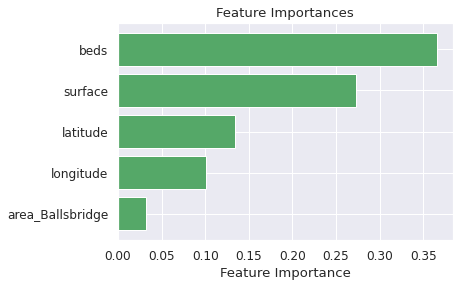

In [184]:
#Determine the most relevant features

model = RandomForestRegressor(random_state=8, max_depth=8)
model.fit(X_train, y_train)

features = train.drop('price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-5:]  # top 5 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

The top 5 features will be used for regression

### Train dataset

# PIECEWISE REGRESSION

## Full Model

In [185]:
# Based on the above results, we select the most important features
dftrain = train
dftest=test
dfcost=test['price']
featrain = ['beds','area_Ballsbridge','latitude', 'longitude', 'surface','price']
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['beds','area_Ballsbridge','latitude', 'longitude','surface']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_subset_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

print(df_subset_train.shape)
print(df_subset_test.shape)
print(df_subset_cost.shape)

(2823, 6)
(500, 5)
(500,)


In [186]:
print(dfcost)

0      875000.0
1      355000.0
2      440000.0
3      425000.0
4      265000.0
         ...   
495    345000.0
496    775000.0
497    360000.0
498    925000.0
499    325000.0
Name: price, Length: 500, dtype: float64


In [187]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = dfcost.values

In [188]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [189]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,893.3


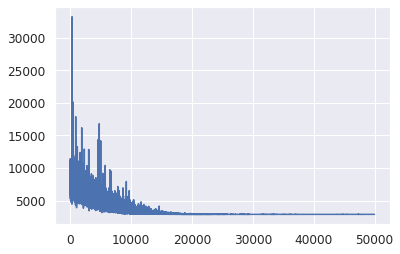

In [190]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [194]:
# samples from the posterior
posterior = approximation.sample(draws=2000)
print(posterior)

<MultiTrace: 1 chains, 2000 iterations, 4 variables>


In [195]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  204919.68915063146
MAPE =  0.26692202959473116


## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)


### Clusters

In [ ]:
# clustering by beds and bathroom


In [ ]:
# clustering by features latitude and longitude


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY